# Synchronization Procedure Demo
mardis@uni-bremen.de

In [4]:
import numpy as np
from matplotlib import pyplot as plt

from pyphysim.channels.fading import TdlChannel, TdlChannelProfile
from pyphysim.channels.fading_generators import JakesSampleGenerator
from pyphysim.modulators import OFDM
from pyphysim.modulators.ofdm import OfdmOneTapEqualizer

from nrphypy import signals, ssb, decode, threegpp_tdl_channels

## Simulation Parameters

In [5]:
# seed for reproducability
np.random.seed(1)

# Physical layer cell identity
N_ID1 = np.random.randint(336) # cell ID group {0,..,335}
N_ID2 = np.random.randint(3)   # cell ID sector {0,1,2}
N_ID_Cell = 3 * N_ID1 + N_ID2  # cell identity ID
nu = N_ID_Cell % 4
# OFDM Parameters 
mu = 0 # Numerology 38.211 Table 4.3.2-1 normal cyclic prefix only (for the second part of the simulation)
CP_SIZE = 100
FFT_SIZE = 1024 #4096
F_d = 2
JAKES_L = 20
F = 2.4e9 # Hz

NOISE = 5e-2

ch = 'TDL_C'

# k_ssb is a combination of higher layer parameters and is to be chosen for the sake of this simulation
# {0,1,2,...,23} for f < 6GHz expressed in multiples of 15kHz SCS
# {0,1,2,...,11} for f >= 6GHz expressed in multiples of 60kHz SCS
# See 38.211 7.4.3.1 
k_ssb = 10


In [6]:
def plot_grid(grid, title=''):
    fig, ax = plt.subplots(figsize=(20, 8), ncols=1)
    ax.pcolormesh(np.array(range(len(grid[0]))) + 0.5, range(len(grid)), np.real(grid), shading='auto')
    ax.set_title(title)
    ax.set_xlabel('OFDM Symbol')
    ax.set_ylabel('Subcarrier')
    plt.colorbar(ax.pcolor(np.real(grid)), ax=ax)

## Channel Model

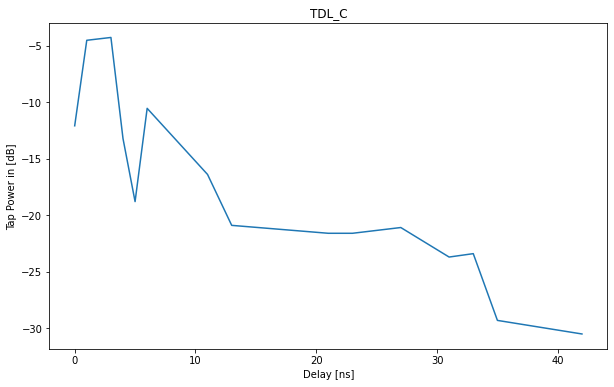

In [7]:
channel = TdlChannel(
    fading_generator = JakesSampleGenerator(Fd=F_d, Ts=1e-8, L=JAKES_L ),
    channel_profile = TdlChannelProfile(*threegpp_tdl_channels.get_channel_profile(ch, ds_desired = 49e-9)))

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title(ch,)
ax.set_ylabel('Tap Power in [dB]')
ax.set_xlabel('Delay [ns]')
_ = ax.plot(channel.channel_profile.tap_delays, channel.channel_profile.tap_powers_dB)

## Synchronization procedure

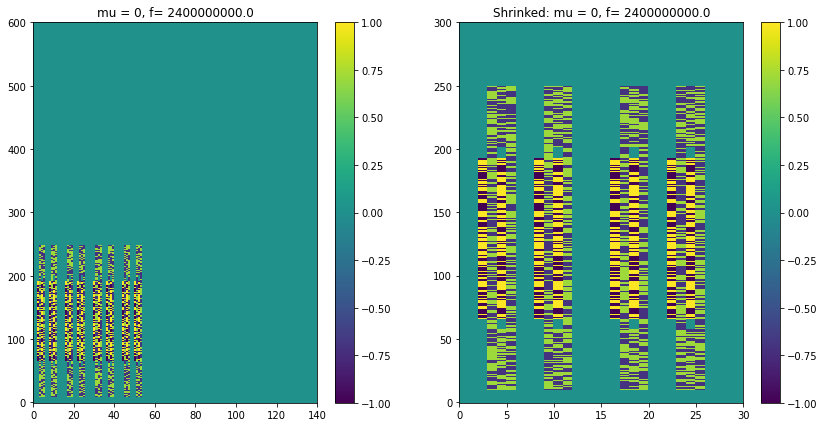

In [24]:
n_carr = 50*12 # Number of RBs 38.101 T-5.3.2-1

rgrid = ssb.grid(n_carr, N_ID1, N_ID2, k_ssb, mu, F,True, False)

fig, [ax1,ax2] = plt.subplots(figsize=(14, 7), ncols = 2)

ax1.set_title('mu = {}, f= {}'.format(mu,F))
ax1.pcolormesh(np.array(range(len(rgrid[0]))) + 0.5, range(len(rgrid)), np.real(rgrid), shading='auto')
plt.colorbar(ax1.pcolor(np.real(rgrid)), ax=ax1)

# Shrinking for easier computation
n_sc = 300
n_symb = 30
rgrid = rgrid[:n_sc, :n_symb]

ax2.set_title('Shrinked: mu = {}, f= {}'.format(mu,F))
ax2.pcolormesh(np.array(range(len(rgrid[0]))) + 0.5, range(len(rgrid)), np.real(rgrid), shading='auto')
plt.colorbar(ax2.pcolor(np.real(rgrid)), ax=ax2)

## Modulation

In [22]:
ofdm_modem = OFDM(FFT_SIZE, CP_SIZE, num_used_subcarriers= n_sc)

s = ofdm_modem.modulate(rgrid.flatten(order='F'))

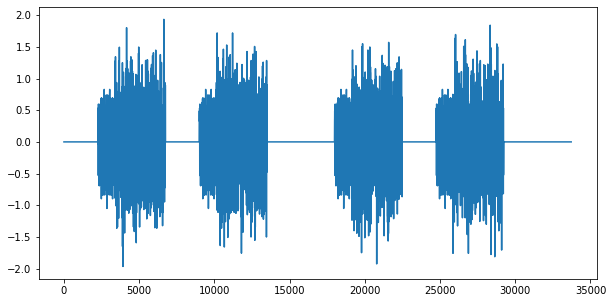

In [21]:
fig, ax2 = plt.subplots(figsize=(10,5))
ax2.plot(range(len(s)), np.real(s))

## Transmission

In [8]:
rec = channel.corrupt_data(s).flatten()
n = np.array([ complex(np.random.normal(0, NOISE, 1) + 1j * np.random.normal(0, NOISE, 1)) for i in range(len(rec))])
rec += n

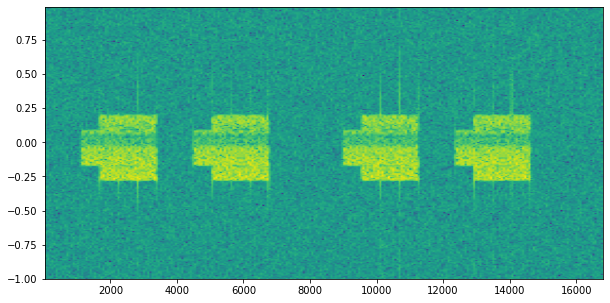

In [9]:
fig, ax3 = plt.subplots(figsize=(10,5))
_ = ax3.specgram(rec)

## Demodulation and equalization

In [10]:
rec_no = rec[:(FFT_SIZE + CP_SIZE) * n_symb]
demod_rec = ofdm_modem.demodulate(rec_no)

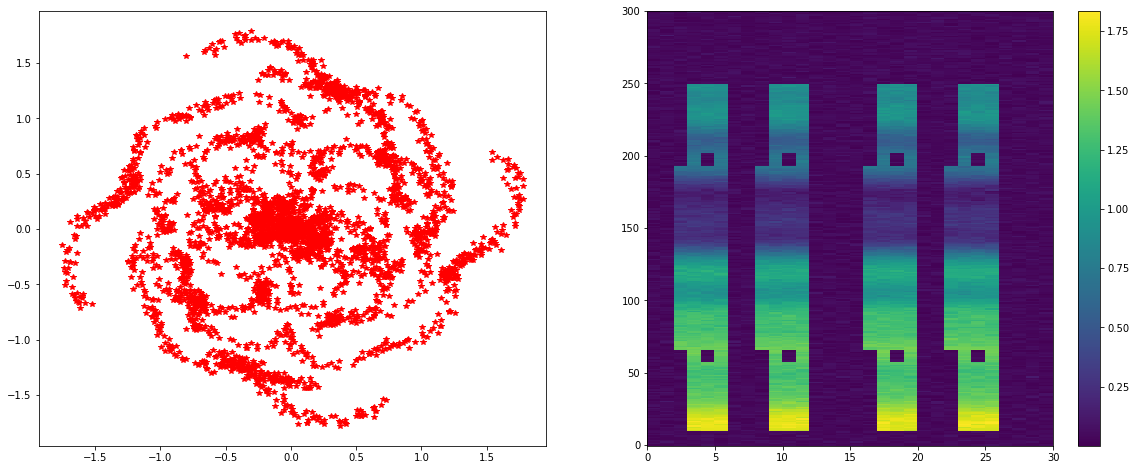

In [11]:
fig, [ax1, ax2] = plt.subplots(figsize=(20, 8), ncols=2)
rec_res_grid = np.transpose(np.resize(demod_rec, (n_symb, n_sc)))
ax2.pcolormesh(np.array(range(len(rec_res_grid[0]))) + 0.5, range(len(rec_res_grid)), np.abs(rec_res_grid), shading='auto')
plt.colorbar(ax2.pcolor(abs(rec_res_grid)))

_= ax1.plot(np.real(rec_res_grid), np.imag(rec_res_grid), 'r*')

In [12]:
eq = OfdmOneTapEqualizer(ofdm_modem)
eq_rec = eq.equalize_data(demod_rec, channel.get_last_impulse_response())

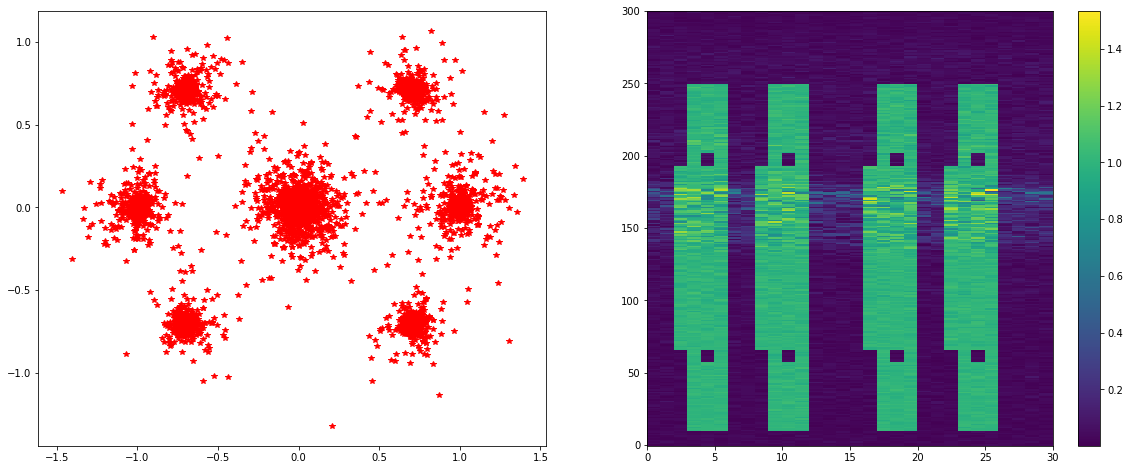

In [13]:
fig, [ax1, ax2] = plt.subplots(figsize=(20, 8), ncols=2)
eq_rec_res_grid = np.transpose(np.resize(eq_rec, (n_symb, n_sc)))
ax2.pcolormesh(np.array(range(len(eq_rec_res_grid[0]))) + 0.5, range(len(eq_rec_res_grid)), np.abs(eq_rec_res_grid), shading='auto')
plt.colorbar(ax2.pcolor(abs(eq_rec_res_grid)))

_ = ax1.plot(np.real(eq_rec_res_grid), np.imag(eq_rec_res_grid), 'r*')

## Decode PSS for N_ID2 and SSB_offsets

In [14]:
rec_nid2, rec_k_offs, rec_l_offs =  decode.decode_pss(eq_rec_res_grid)
print('recorded N_ID2:{}\nk_offset:{}\nl_offset:{}\n\nN_ID2:{}\nk_offset:{}'
      .format(rec_nid2, rec_k_offs, rec_l_offs,N_ID2, k_ssb))
eq_rec_ssb = ssb.unmap_ssb(eq_rec_res_grid,rec_k_offs,rec_l_offs)

recorded N_ID2:0
k_offset:10
l_offset:22

N_ID2:0
k_offset:10


## Decode SSS for complete N_ID_Cell

In [15]:
rec_sss = ssb.unmap_sss(eq_rec_ssb)
rec_nid1 = decode.decode_sss(rec_sss, rec_nid2)
rec_n_id_cell = 3 * rec_nid1 + rec_nid2

rec_nu = rec_n_id_cell % 4

print('N_ID1:{}\nN_ID_Cell:{}\nnu:{}\nrecN_ID1:{}\nrecN_ID_Cell:{}\nrecnu:{}:'
      .format(N_ID1, N_ID_Cell, nu, rec_nid1, rec_n_id_cell, rec_nu))


N_ID1:37
N_ID_Cell:111
nu:3
recN_ID1:37
recN_ID_Cell:111
recnu:3:


## Decode PBCH for MIB

## misc

In [ ]:
N_ID1 = 123
N_ID2 = 0
N_ID_Cell = 3 * N_ID1 + N_ID2  # cell identity ID

k_ssb = 10

av_mu = [0,1,3] #[0,1,3,4]
av_f = [1e9, 10e9] # representatives for FR1 and FR2
av_sharedspectrum = [False] #[True, False]
av_pairedspectrum = [False]#[True, False]

av_configs = [[i,j,k,l] for i in av_mu for j in av_f for k in av_sharedspectrum for l in av_pairedspectrum]
av_configs = [x for x in av_configs if ssb.get_ssb_candidate_idx(*x).size] # Filter permutations which are not allowed (FR2)

fig, ax = plt.subplots(figsize=(25,30), nrows= len(av_configs))
ax = np.array(ax)
for i, conf in enumerate(av_configs):
    rgrid = ssb.grid(300, N_ID1, N_ID2, k_ssb, *conf,)
    ax[i].set_title('mu = {}, f = {} Hz, shared spectrum = {}, paired spectrum = {}'.format(*conf))
    ax[i].pcolormesh(
        np.array(range(len(rgrid[0]))) + 0.5, 
        range(len(rgrid)), 
        np.abs(rgrid), 
        shading='auto')
    plt.colorbar(ax[i].pcolor(np.abs(rgrid)), ax=ax[i])


Text(0, 0.5, 'Subcarrier')

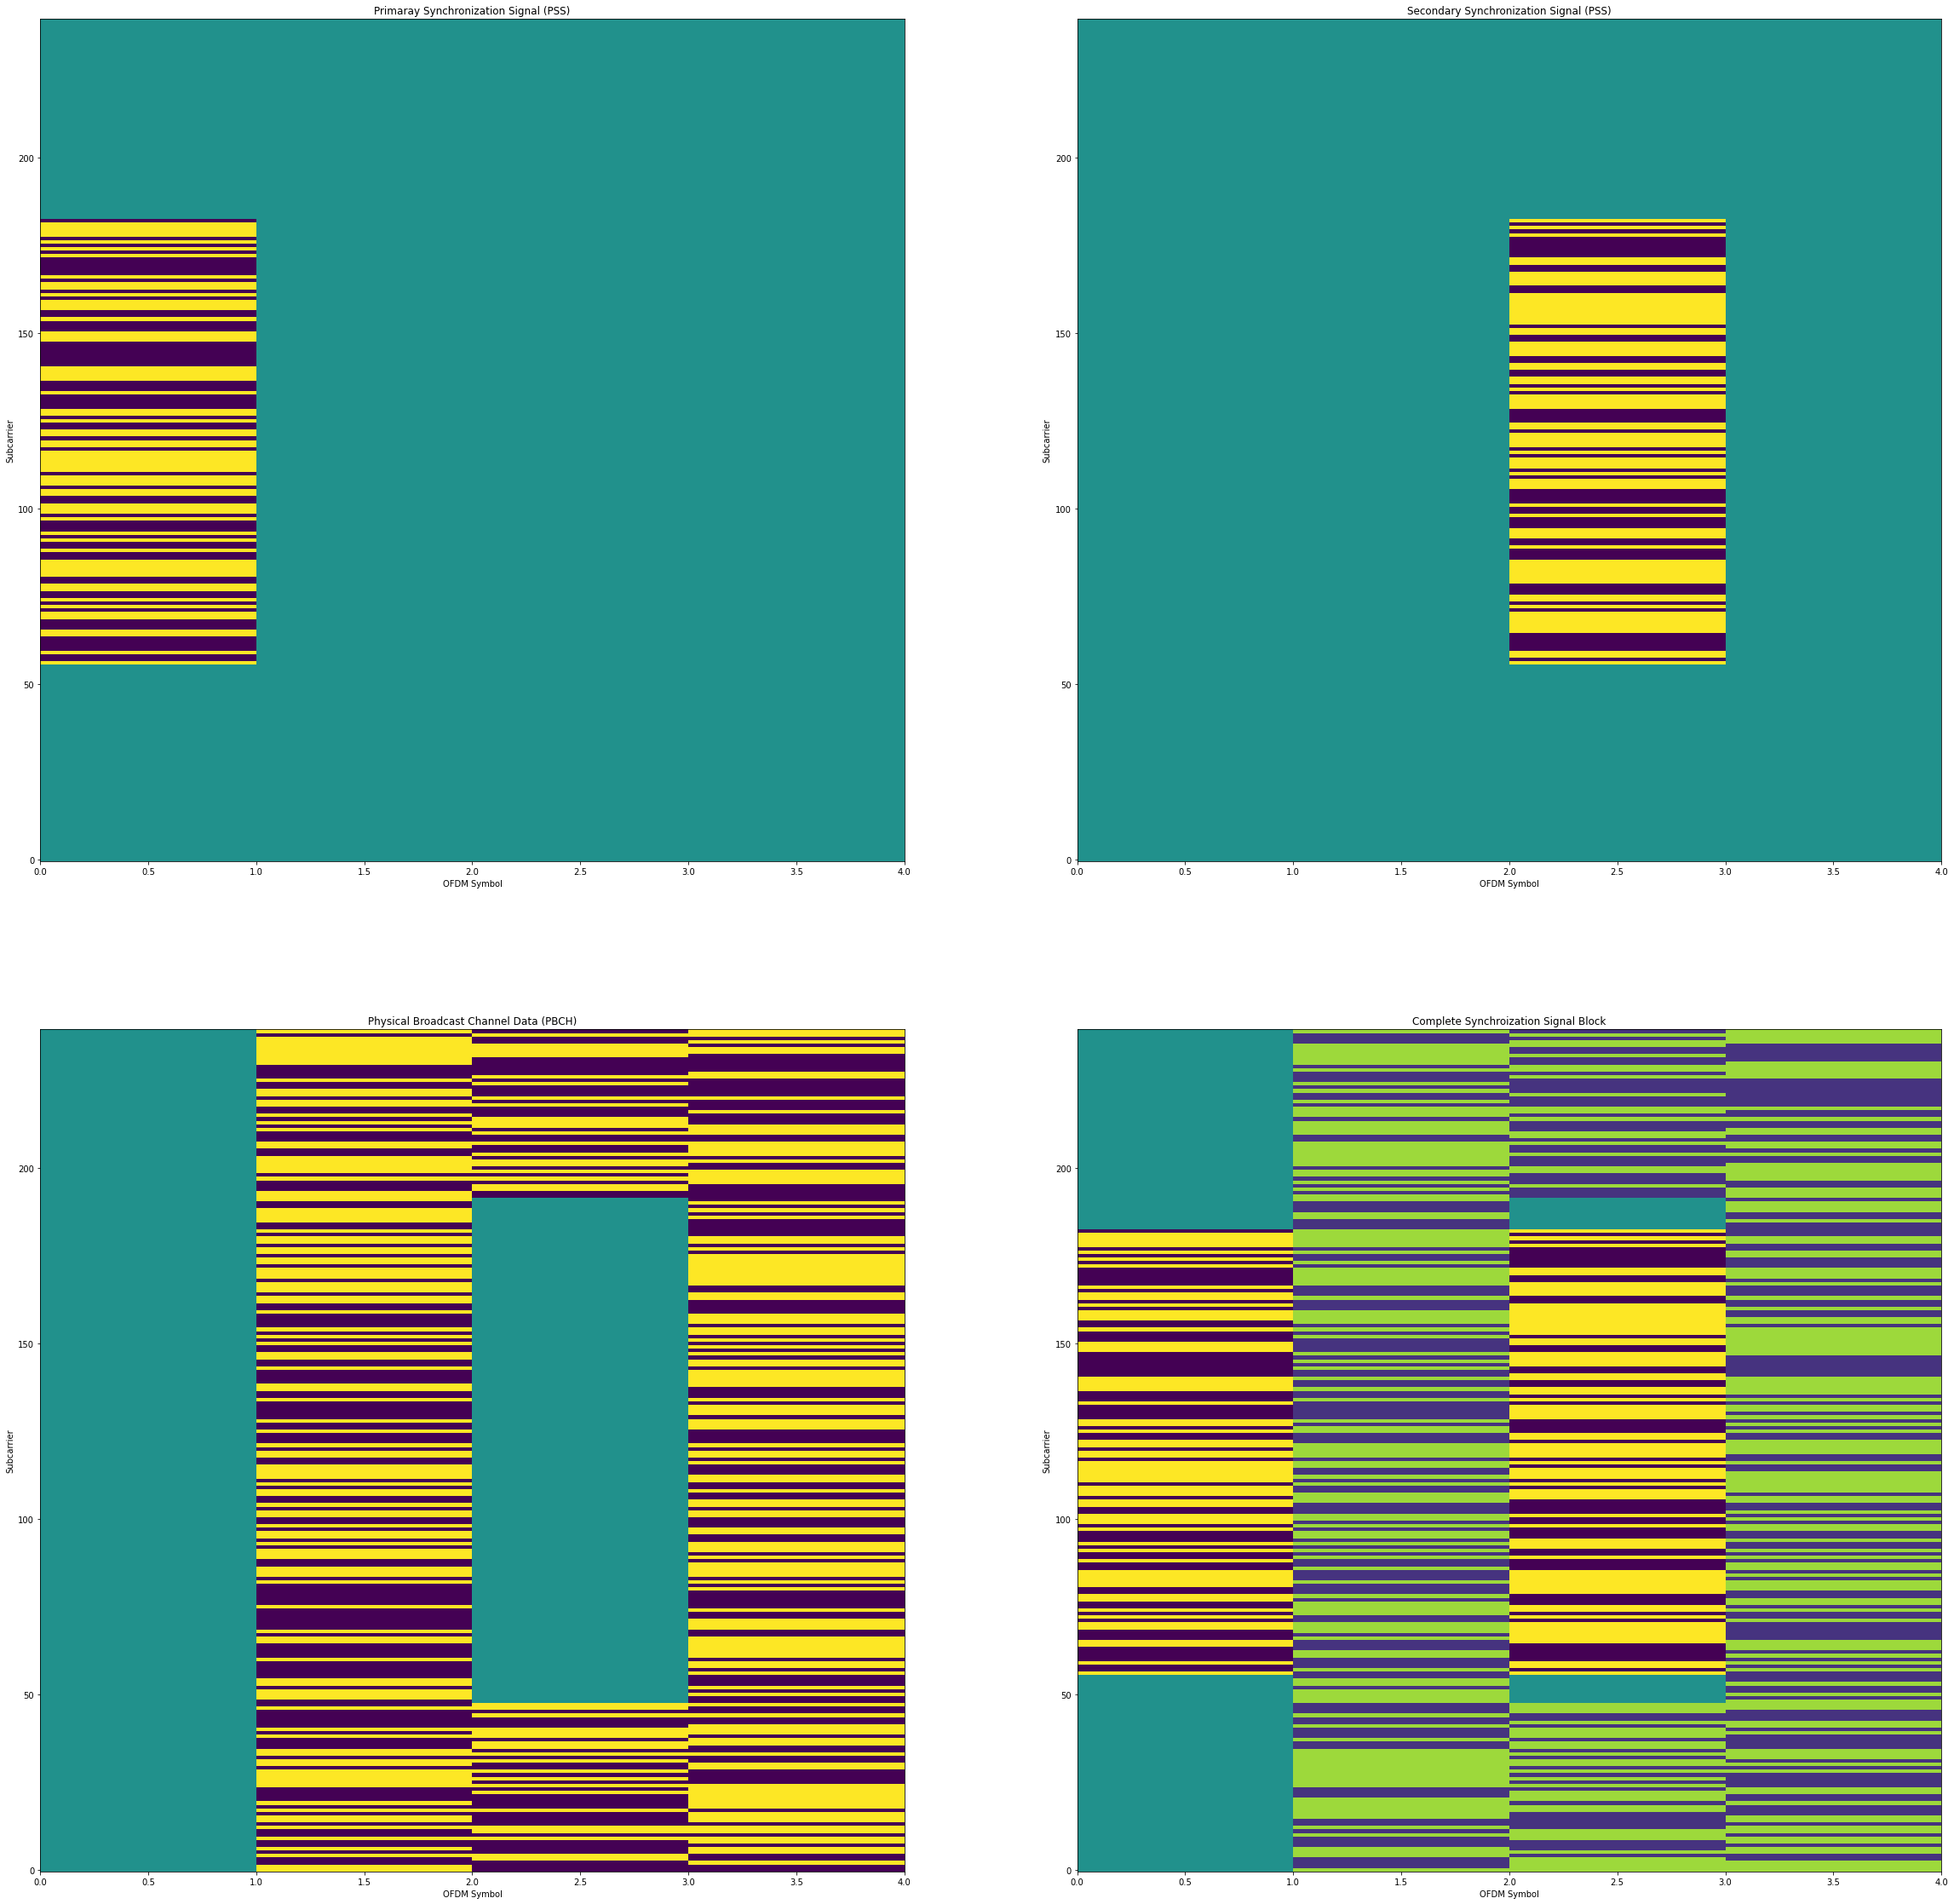

In [25]:
rgrid = ssb.grid(240, N_ID1, N_ID2, 0, 0, 1e9, False, False)[:240,2:6]

fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(figsize=(40,40), ncols = 2, nrows=2)
nu = N_ID_Cell % 4
 
pss = signals.pss(N_ID2)
rgrid_pss = ssb.map_pss(pss)

sss =  signals.sss(
        N_ID1 = N_ID1,
        N_ID2 = N_ID2)

rgrid_sss = ssb.map_sss(sss)

pbch= signals.pbch(
        np.random.randint(2, size=864),
        len(ssb.get_ssb_candidate_idx(0, 1e9, False, False)),
        N_ID_Cell,
        0)

dmrs = signals.dmrs(0, N_ID_Cell, len(ssb.get_ssb_candidate_idx(0, 1e9, False, False)), 0)


rgrid_pbch = ssb.map_pbch(pbch, dmrs, nu)


ax1.pcolormesh(np.array(range(len(rgrid_pss[0]))) + 0.5, range(len(rgrid_pss)), np.real(rgrid_pss), shading='auto')
ax1.set_title('Primaray Synchronization Signal (PSS)')
ax1.set_xlabel('OFDM Symbol')
ax1.set_ylabel('Subcarrier')


ax2.pcolormesh(np.array(range(len(rgrid_sss[0]))) + 0.5, range(len(rgrid_sss)), np.real(rgrid_sss), shading='auto')
ax2.set_title('Secondary Synchronization Signal (PSS)')
ax2.set_xlabel('OFDM Symbol')
ax2.set_ylabel('Subcarrier')

ax3.pcolormesh(np.array(range(len(rgrid_pbch[0]))) + 0.5, range(len(rgrid_pbch)), np.real(rgrid_pbch), shading='auto')
ax3.set_title('Physical Broadcast Channel Data (PBCH)')
ax3.set_xlabel('OFDM Symbol')
ax3.set_ylabel('Subcarrier')


ax4.pcolormesh(np.array(range(len(rgrid[0]))) + 0.5, range(len(rgrid)), np.real(rgrid), shading='auto')
ax4.set_title('Complete Synchroization Signal Block')
ax4.set_xlabel('OFDM Symbol')
ax4.set_ylabel('Subcarrier')
